# Stage 1: Disjoint Sets

In [15]:
class DisjointSet:
    def __init__(self):
        self.parent = {}
        self.rank = {}
        
    def make_set(self, label):
        # Make itself the 'label' for this connected component
        self.parent[label] = label
        self.rank[label] = 0
    
    def union(self, label_a, label_b):
        self.link(self.find(label_a), self.find(label_b))
    
    def find(self, label):
        '''
        Find what component the label (vertex) is in

        Recall components are 'labeled' by one of the vertices inside of them that is the root of that component subtree

        Ex: If (1,1) does not have (1,1) as a parent, then it is part of a larger component
        Keep traversing up parent tree until get parent as itself, this is the root that defines the component
        Return that - (1,1) is inside the component labelled by that vertex
        '''
        if label not in self.parent:
            # This vertex has not yet been added to the disjoint set, return no component
            return None

        if self.parent[label] != label:
            # Path compression
            self.parent[label] = self.find(self.parent[label])

        # At this point path-compressed so can return directly
        return self.parent[label]

    def link(self, component_a, component_b):
        '''
        Combine two connected components (merge sets)
        '''
        if self.rank[component_a] > self.rank[component_b]:
            # Choose smaller component to be subcomponent to reduce find (path compression) work later
            self.parent[component_b] = component_a
        else:
            self.parent[component_a] = component_b
            if self.rank[component_a] == self.rank[component_b]:
                self.rank[component_b] = self.rank[component_b] + 1


## Tests

In [16]:
ds = DisjointSet()
ds.make_set(1)
ds.make_set(2)

assert ds.find(1) == 1
assert ds.find(2) == 2

ds.union(1, 2)
assert ds.find(1) == ds.find(2)

# Stage 2: Grids and Neighborhoods

In [64]:
import matplotlib.pyplot as plt
import matplotlib.tri as mtri
import numpy as np

def plot(grid):
    plt.imshow(grid)
    
    def subthing():
        tris = []
        # numtris = 1
        for y in range(grid.shape[0]-1):
            for x in range(grid.shape[1]-1):
                # Output triangles to bottom and left
                ind = y * grid.shape[1] + x
                tri1 = [
                    ind,
                    ind + grid.shape[1],
                    ind + grid.shape[1] + 1
                ]
                tri2 = [
                    ind,
                    ind + grid.shape[1] + 1,
                    ind + 1
                ]
                # print(tri1, tri2)
                tris.append(tri1)
                tris.append(tri2)
                # numtris -= 1
                # if numtris == 0:
                #     return tris
        return tris
    
    tris = subthing()
    yrange = np.arange(grid.shape[0])
    xrange = np.arange(grid.shape[1])
    xx, yy = np.meshgrid(xrange, yrange, sparse=False)
    triangulation = mtri.Triangulation(xx.flatten(), yy.flatten(), triangles=tris)

    # print(triangulation)

    plt.triplot(triangulation)


    # Annotate values
    for j in yrange:
        for i in xrange:
            plt.annotate(grid[j,i], (i,j))


    # Generate an OBJ mesh TODO: extract as sub function
    xy_scale = 10.0
    z_scale = 0.25
    for j in yrange:
        for i in xrange:
            # print(i, j, grid[j,i])
            # Invert the y to make it accurate as model
            # print(f'v {float(i)*xy_scale} {float(grid.shape[0] - 1 - j)*xy_scale} {float(grid[j,i])*z_scale}')
            print(f'v {float(i)*xy_scale} {float(grid[j,i])*z_scale} {float(grid.shape[0] - 1 - j)*xy_scale} ')
            
    print()
    for tri in tris:
        # OBJ does 1 indexing
        # print(f'f {tri[0]+1} {tri[1]+1} {tri[2]+1}')
        print(f'f {tri[2]+1} {tri[1]+1} {tri[0]+1}')
    



def neighbors(grid, vertex):
    '''
    Get direct neighbors

    NOTE: assumes vertex is 1D vertex

    Triangulation:

    o---o---o
    | \ | \ |
    o---o---o
    | \ | \ |
    o---o---o

    Neighbors of x:

    n---n---o
    | \ | \ |
    n---x---n
    | \ | \ |
    o---n---n

    Edge cases:

    n---o    n---o         
    | \ |    | \ |         
    x---n    x---n    x---n
    | \ |             | \ |
    n---n             n---n

    n---n    n---n         
    | \ |    | \ |         
    n---x    n---x    n---x
    | \ |             | \ |
    o---n             o---n
    
    '''

    # Turn 1D vertex into 2D
    vertex = np.unravel_index(vertex, grid.shape)

    # x,y = vertex
    y,x = vertex

    yMin, xMin = 0, 0
    yMax, xMax = np.subtract(grid.shape, 1)

    #center = grid[y,x]

    # # EDGE CASES: yMin, xMin, yMax, xMax
    # neighbors = np.array([
    #     grid[y-1, x-1], # ! yMin, xMin
    #     grid[y-1, x  ], # ! yMin
    #     grid[y  , x-1], # !       xMin
    #     grid[y  , x+1], # !       xMax
    #     grid[y+1, x  ], # ! yMax
    #     grid[y+1, x+1], # ! yMax, xMax
    # ])

    # notYMin = y != yMin
    # notXMin = x != xMin
    # notYMax = y != yMax
    # notXMax = x != xMax

    # select = [
    #     notYMin and notXMin,
    #     notYMin,
    #     notXMin,
    #     notXMax,
    #     notYMax,
    #     notYMax and notXMax
    # ]

    notYMin = y != yMin
    notXMin = x != xMin
    notYMax = y != yMax
    notXMax = x != xMax

    # EDGE CASES: yMin, xMin, yMax, xMax
    # neighbors = np.array([
    #     grid[y-1, x-1] if notYMin and notXMin else 0,
    #     grid[y-1, x  ] if notYMin else 0,
    #     grid[y  , x-1] if notXMin else 0,
    #     grid[y  , x+1] if notXMax else 0,
    #     grid[y+1, x  ] if notYMax else 0,
    #     grid[y+1, x+1] if notYMax and notXMax else 0,
    # ])

    neighbors = np.array([
        (y-1, x-1),
        (y-1, x  ),
        (y  , x-1),
        (y  , x+1),
        (y+1, x  ),
        (y+1, x+1),
    ])

    select = [
        notYMin and notXMin,
        notYMin,
        notXMin,
        notXMax,
        notYMax,
        notYMax and notXMax
    ]
    

    return neighbors[select]
    # return neighbors[np.nonzero(neighbors)]

## Example Dataset

This dataset has three maxima, two saddles, and three minima.

In [18]:
grid = np.array([
    [29, 37, 39, 70, 74, 84, 38, 36, 26],
    [27, 100, 49, 72, 85, 89, 83, 28, 24],
    [25, 47, 50, 73, 86, 90, 71, 82, 22],
    [23, 75, 79, 48, 69, 87, 88, 81, 18],
    [19, 76, 80, 78, 46, 68, 67, 40, 16],
    [17, 41, 77, 45, 35, 20, 21, 32, 15],
    [13, 42, 43, 44, 34, 33, 31, 30, 14],
    [12, 11, 10, 9, 8, 7, 6, 5, 0]])

In [19]:
print(grid[1,1])
print(grid[2,5])
print(grid[1,5])

tgrid_linear = grid.flatten()
# Gives indices of sorted order
tsorted_vertices = np.argsort(tgrid_linear)[::-1] # reversed

print(tsorted_vertices[0:5])
print(np.unravel_index(tsorted_vertices[0:5], grid.shape))

100
90
89
[10 23 14 33 32]
(array([1, 2, 1, 3, 3], dtype=int64), array([1, 5, 5, 6, 5], dtype=int64))


## Grid Test Cases

In [20]:
#TODO


def convert_index(grid, vertex):
    '''
    TODO: I think this is same as just np.ravel_multi_index(vertex, grid.shape)
    '''
    x,y = vertex
    return (x * grid.shape[1]) + y


print('(1,1) -->', convert_index(grid, (1,1)))
print('(0,0) -->', convert_index(grid, (0,0)))
print('(1,0) -->', convert_index(grid, (1,0)))
print('(0,1) -->', convert_index(grid, (0,1)))


# Actually do (y, x)
print("Actual: ", neighbors(grid, convert_index(grid, (1,1))), "Expected: [29 37 27 49 47 50]")
print("Actual: ", neighbors(grid, convert_index(grid, (0,0))), "Expected: [ 37  27 100]")
print("Actual: ", neighbors(grid, convert_index(grid, (1,0))), "Expected: [ 29  39 100  49]")
print("Actual: ", neighbors(grid, convert_index(grid, (0,1))), "Expected: [ 29 100  25  47]")

(1,1) --> 10
(0,0) --> 0
(1,0) --> 9
(0,1) --> 1
Actual:  [[0 0]
 [0 1]
 [1 0]
 [1 2]
 [2 1]
 [2 2]] Expected: [29 37 27 49 47 50]
Actual:  [[0 1]
 [1 0]
 [1 1]] Expected: [ 37  27 100]
Actual:  [[0 0]
 [1 1]
 [2 0]
 [2 1]] Expected: [ 29  39 100  49]
Actual:  [[0 0]
 [0 2]
 [1 1]
 [1 2]] Expected: [ 29 100  25  47]


v 0.0 7.25 70.0 
v 10.0 9.25 70.0 
v 20.0 9.75 70.0 
v 30.0 17.5 70.0 
v 40.0 18.5 70.0 
v 50.0 21.0 70.0 
v 60.0 9.5 70.0 
v 70.0 9.0 70.0 
v 80.0 6.5 70.0 
v 0.0 6.75 60.0 
v 10.0 25.0 60.0 
v 20.0 12.25 60.0 
v 30.0 18.0 60.0 
v 40.0 21.25 60.0 
v 50.0 22.25 60.0 
v 60.0 20.75 60.0 
v 70.0 7.0 60.0 
v 80.0 6.0 60.0 
v 0.0 6.25 50.0 
v 10.0 11.75 50.0 
v 20.0 12.5 50.0 
v 30.0 18.25 50.0 
v 40.0 21.5 50.0 
v 50.0 22.5 50.0 
v 60.0 17.75 50.0 
v 70.0 20.5 50.0 
v 80.0 5.5 50.0 
v 0.0 5.75 40.0 
v 10.0 18.75 40.0 
v 20.0 19.75 40.0 
v 30.0 12.0 40.0 
v 40.0 17.25 40.0 
v 50.0 21.75 40.0 
v 60.0 22.0 40.0 
v 70.0 20.25 40.0 
v 80.0 4.5 40.0 
v 0.0 4.75 30.0 
v 10.0 19.0 30.0 
v 20.0 20.0 30.0 
v 30.0 19.5 30.0 
v 40.0 11.5 30.0 
v 50.0 17.0 30.0 
v 60.0 16.75 30.0 
v 70.0 10.0 30.0 
v 80.0 4.0 30.0 
v 0.0 4.25 20.0 
v 10.0 10.25 20.0 
v 20.0 19.25 20.0 
v 30.0 11.25 20.0 
v 40.0 8.75 20.0 
v 50.0 5.0 20.0 
v 60.0 5.25 20.0 
v 70.0 8.0 20.0 
v 80.0 3.75 20.0 
v 0.0 3.25 10.0 
v 10.0 10.5

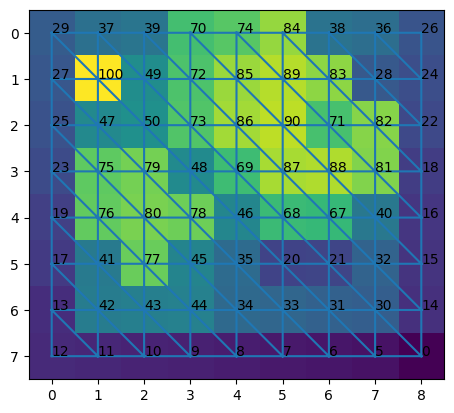

In [65]:
plot(grid)
print(grid.shape)

v 0.0 0.0 70.0 
v 10.0 0.0 70.0 
v 20.0 0.0 70.0 
v 30.0 0.0 70.0 
v 40.0 0.0 70.0 
v 50.0 0.0 70.0 
v 60.0 0.0 70.0 
v 70.0 0.0 70.0 
v 80.0 0.0 70.0 
v 0.0 0.0 60.0 
v 10.0 0.0 60.0 
v 20.0 0.0 60.0 
v 30.0 0.0 60.0 
v 40.0 0.0 60.0 
v 50.0 0.0 60.0 
v 60.0 0.0 60.0 
v 70.0 0.0 60.0 
v 80.0 0.0 60.0 
v 0.0 0.0 50.0 
v 10.0 0.0 50.0 
v 20.0 0.0 50.0 
v 30.0 0.0 50.0 
v 40.0 0.0 50.0 
v 50.0 0.0 50.0 
v 60.0 0.0 50.0 
v 70.0 0.0 50.0 
v 80.0 0.0 50.0 
v 0.0 0.0 40.0 
v 10.0 0.0 40.0 
v 20.0 0.0 40.0 
v 30.0 0.0 40.0 
v 40.0 0.0 40.0 
v 50.0 0.0 40.0 
v 60.0 0.0 40.0 
v 70.0 0.0 40.0 
v 80.0 0.0 40.0 
v 0.0 0.0 30.0 
v 10.0 0.0 30.0 
v 20.0 0.0 30.0 
v 30.0 0.0 30.0 
v 40.0 0.0 30.0 
v 50.0 0.0 30.0 
v 60.0 0.0 30.0 
v 70.0 0.0 30.0 
v 80.0 0.0 30.0 
v 0.0 0.0 20.0 
v 10.0 0.0 20.0 
v 20.0 0.0 20.0 
v 30.0 0.0 20.0 
v 40.0 0.0 20.0 
v 50.0 0.0 20.0 
v 60.0 0.0 20.0 
v 70.0 0.0 20.0 
v 80.0 0.0 20.0 
v 0.0 0.0 10.0 
v 10.0 0.0 10.0 
v 20.0 0.0 10.0 
v 30.0 0.0 10.0 
v 40.0 0.0 10.0 
v 50

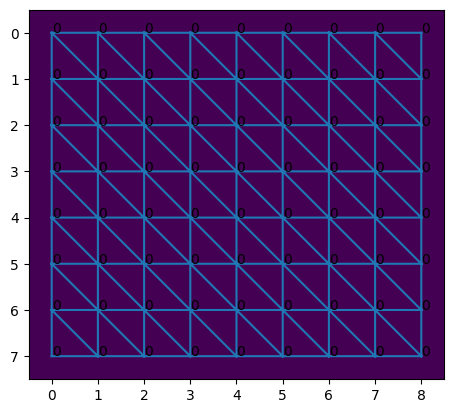

In [66]:
grid2 = np.array([
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0]])

plot(grid2)

# Stage 3: Tree Data Structure

An example of tree data structure that uses grid vertices as identifiers of nodes.

In [29]:
class Node:
    def __init__(self, vertex, children, parents, value):
        '''
        Constructor

        Genreate node with the vertex, set of children of this node, set of parents of this node, and the value (isovalue) of this node
        '''
        self.vertex = vertex
        self.children = children # list/set of children
        self.parents = parents # list/set of parents
        self.value = value

#NOTE: see removed comments #1

class Tree:
    def __init__(self):
        self.vertex_to_node = {}

    def compute_significants(self):
        '''
        #TODO: move this out maybe into another func and just return the set

        Go through all vertices and find 'significant' nodes

        IE, if they are root (parents is empty), leaf (children is empty), or merge (multiple parents) 
        '''

        significants = set()
        sigroots = set()

        for vert, node in self.vertex_to_node.items():
            if len(node.parents) == 0:
                # Root
                significants.add(vert)
                sigroots.add(vert)
            elif len(node.children) == 0:
                # Leaf
                significants.add(vert)
            elif len(node.parents) > 1:
                # Merge
                significants.add(vert)
            elif len(node.children) > 1:
                # Merge, but in opposite direction
                #NOTE: Should ONLY be done on contour tree! check if JT/ST is in here, then something went wrong
                significants.add(vert)

        return (significants, sigroots)

    def gen_sigtree(self, significants_verts, sigroots_verts):
        def walk_to_next_sig(node):
            '''
            Returns list of walking down all branches from this node until we hit a significant node in that branch
            '''
            next_sigs = []
            walk_stack = [v for v in node.children]
            # Don't need marked here b/c assume no cycles
            while len(walk_stack) > 0:
                successor_node = walk_stack.pop()
                #if successor_node.vertex in significants:
                if successor_node in significants:
                    next_sigs.append(successor_node)
                else:
                    walk_stack.extend(successor_node.children)
            return next_sigs

        # We want to append all roots first and then walk down the tree to get the connections
        sigtree = Tree()
        significants = {self.vertex_to_node[v] for v in significants_verts}
        sigroots = {self.vertex_to_node[v] for v in sigroots_verts}

        stack = [v for v in sigroots]
        marked = set()

        # # Add all roots to new tree
        # for root in sigroots:
        #     #sigtree.add_child(parent=None, child=root, value=self.vertex_to_node[root].value)
        #     sigtree.add_child(parent=None, child=root.vertex, value=root.value)

        # Add all vertices to new tree
        for significant_vert in significants:
            sigtree.add_node(vertex=significant_vert.vertex, value=significant_vert.value)

        while len(stack) > 0:
            signode = stack.pop()
            if signode not in marked:
                marked.add(signode)
                next_connected_significants = walk_to_next_sig(node=signode) # children significants of this signode
                for next_signode in next_connected_significants:
                    # Add edge from current node to its successors
                    #sigtree.add_child(parent=signode.vertex, child=next_signode.vertex, value=next_signode.value)
                    sigtree.connect_nodes(parent=signode.vertex, child=next_signode.vertex)
                    # Add all successor significants to queue
                    stack.append(next_signode)

        return sigtree

    def get_node(self, vert):
        '''
        Get the Node object corresponding to the vertex

        O(1) with dictionary lookup
        '''
        return self.vertex_to_node[vert] if vert in self.vertex_to_node else None
    
    def is_root(self, vert):
        '''
        For both the join and split trees, we have the upper/lower leaves as just when no parents

        As for join tree, upper leaves with no parents will be at the top, but for split tree we draw it upside down, so the lower leaves are also at the top with no parents
        '''

        return self.degree(vert) == 0
    
    def degree(self, vert):
        '''
        For both the join and split trees, we have the upper/lower leaves as just when no parents

        As for join tree, upper leaves with no parents will be at the top, but for split tree we draw it upside down, so the lower leaves are also at the top with no parents
        '''

        return len(self.vertex_to_node[vert].parents)
    
    # def get_create_node(self, vert):
    #     '''
    #     Gets node or creates if does not exist
    #     '''

    #     node = self.get_node(vert)
    #     if node is None:
    #         # Does not exist so create
    #         node = Node(set(), {vert}, None)

    #     return node


    def add_node(self, vertex, value):
        '''
        Creates the vertex, if it does not exist

        Returns True if created vertex, False otherwise
        '''
        node = self.get_node(vertex)
        if node is None:
            node = Node(vertex=vertex, children=set(), parents=set(), value=value)
            self.vertex_to_node[vertex] = node

            # Did create
            return True
        
        # Did not create
        return False
    
    def connect_nodes(self, parent, child):
        '''
        Makes a connection between two existing nodes

        Will add child to children list of parent, will add parent to parents list of child
        '''
        parent_node = self.get_node(parent)
        child_node = self.get_node(child)

        if (parent_node is None) or (child_node is None):
            raise Exception("Nodes being connected have not been added to the graph yet")
        
        child_node.parents.add(parent_node)
        parent_node.children.add(child_node)

    def get_children(self, vert):
        '''
        Get children of a given node vertex
        '''
        return self.vertex_to_node[vert].children

    def add_child(self, parent, child, value):
        #TODO: when rewrite this maybe make it so you can just add a vertex, no parents/children, and then allow modifying to add parents/children, as currently 
        # this requires specifying a parent which is meh
        '''
        DO NOT USE

        Replaced with add_node(vertex) and connect_nodes(parent, child)

        Adds a child to the given node

        parent - parent vertex; None if this is a new root
        child - child vertex

        '''

        raise Exception("add_child() is depracated")

        #TODO: actually instead of doing the node, maybe just make parent and children store the vertices?
        
        # To handle disconnnected, sort of; but then need to be able to properly connect existing components
        # if vert is None:
        #     self.vertex_to_node[child] = Node([], None, value)
        # else:
        
        #node = self.vertex_to_node[vert]
        parent_node = self.get_node(parent)
        child_node = self.get_node(child)
        if child_node is None:
            # Does not exist so create it
            #TODO: extract as create node
            child_node = Node(vertex=child, children=set(), parents=set(), value=value)
            self.vertex_to_node[child] = child_node
        #else: add to significant nodes b/c this must be a merge point

        #TODO: this is temporary maybe but need to be able to add children before parents for CT generation, so create parent if it does not exist first
        # We really need a flow of having an add_vertex(self, vertex, value), and then this is connect_vertex(self, parent, child) which just makes connection
        if (parent is not None) and (parent_node is None):
            # Parent doesn't exist so create it
            # Use -1 value for now, we will fix it later when we end up attaching shit to it but this is terrible so fix it later
            parent_node = Node(vertex=parent, children=set(), parents=set(), value=-1)
            self.vertex_to_node[parent] = parent_node
        child_node.value = value
        #END TODO
        
        #child_node.parents.add(parent_node)
        
        if parent_node is not None:
            child_node.parents.add(parent_node)
            parent_node.children.add(child_node)

    def reduce_vert(self, vert):
        '''
        Performs a reduction

        if a->b->c, and we reduce_vert(b), we expect a final graph a->c

        Children of b should connect into parent of c
        '''

        node = self.get_node(vert)

        if len(node.parents) > 1:
            # We shouldn't get this for a contour tree
            raise Exception("Multiple parents on node getting reduced, not possible on CT I think...?")

        for child_node in node.children:
            child_node.parents.remove(node)
            
            # This should really never happen for contour tree... so if we have more than 1 parents something went wrong
            for parent_node in node.parents:
                child_node.parents.add(parent_node)
        
        # Again, should really only have one parent...
        for parent_node in node.parents:
            parent_node.children.remove(node)

            for child_node in node.children:
                parent_node.children.add(child_node)


        # Remove the node
        self.vertex_to_node.pop(vert)

    def remove_subtree(self, vert):
        '''
        Removes the subtree under vert
        '''

        #toRemove = self.vertex_to_node[vert]
        to_remove = self.get_node(vert)

        if to_remove is None:
            return
        
        # Remove from children list of all parents
        for parent in to_remove.parents:
            parent.children.remove(to_remove)

        # Given this is tree, that should be the only connection, so now the vertex is disconnected

        del self.vertex_to_node[to_remove]

    def get_dot(self):
        '''
        Get tree as DOT output for visualization
        '''

        def node_string(node):
            return f'"{node.vertex},{node.value}"'

        dot_string = 'digraph G {\n'

        #r1 [style=invis];...rN [style=invis]; r1 -> r2 -> ... -> rN [style=invis];
        dot_head = ''
        #{rank=same; r1; "v1";}...{rank=same; rN; "vN";}
        dot_tail = ''

        # all_nodes = []
        # for _, node in self.vertex_to_node.items():
        #     dot_head += f"r{node.vertex} [style=invis];\n"
        #     all_nodes.append(node)

        # all_nodes.sort(key=lambda n: n.value, reverse=True)
        # dot_head += f"r{all_nodes[0].vertex}"
        # dot_tail += f'{{rank=same; r{all_nodes[0].vertex}; {node_string(all_nodes[0])};}}\n'
        # for node in all_nodes[1:]:
        #     dot_head += f" -> r{node.vertex}"
        #     dot_tail += f'{{rank=same; r{node.vertex}; {node_string(node)};}}\n'
        # dot_head += " [style=invis];\n"

        #NOTE: have to do it this way as it seems it uses the R names somehow in laying things out... so hopefully never get > 100 nodes b/c who knows how r1 vs r100 compare
        #NOTE: wait nvm the issue is you want the definition of the head r1 [style=invis] to be in the same order as the arrows r1->r2->...
        all_nodes = []
        for _, node in self.vertex_to_node.items():
            all_nodes.append(node)

        all_nodes.sort(key=lambda n: n.value, reverse=True)

        for i in range(len(all_nodes)):
            dot_head += f"r{i} [style=invis];\n" #TODO: can replace instad with the r{node.vertex} if we want and it will be fine b/c this is in the sorted order here
        
        dot_head += f"r0"
        dot_tail += f'{{rank=same; r0; {node_string(all_nodes[0])};}}\n'
        for i, node in enumerate(all_nodes[1:]):
            dot_head += f" -> r{i+1}"
            dot_tail += f'{{rank=same; r{i+1}; {node_string(node)};}}\n'
        dot_head += " [style=invis];\n"

        dot_body = ''

        for vert, node in self.vertex_to_node.items():
            # Draw an arrow to each child
            for child_node in node.children:
                #dot_body += f"{vert} -> {child_node.vertex};\n"
                #dot_body += f'"{np.unravel_index(vert, grid.shape)}" -> "{np.unravel_index(child_node.vertex, grid.shape)}";\n'
                #dot_body += f'"{node.vertex},{node.value}" -> "{child_node.vertex},{child_node.value}";\n'
                dot_body += f'{node_string(node)} -> {node_string(child_node)};\n'


        dot_string += dot_head + dot_body + dot_tail + "}"

        return dot_string

# Stage 4: The Sweep Algorithm

In [30]:
#TODO refactor so add_node() is done for evyerthing at the start, and inside we just do connect_node()

def sweep_algorithm(grid, is_join=True):
    merge_tree = Tree()

    #TODO: do this better?
    # For every component, we want to know the lowest (or highest for join tree) isovalue node so we know what parent
    # to connect to for regular or merge vertex
    component_boundary_vertex = {}
    
    # 1. Sort vertices
    
    # Linearize grid and just use 1D indices as the vertices
    #TODO: can use unravel_index to get back 2D indices
    grid_linear = grid.flatten()
    # Gives indices of sorted order
    
    # CREATES MERGE TREE
    # sorted_vertices = np.argsort(grid_linear)[::-1] # reversed

    # CREATES JOIN TREE
    # sorted_vertices = np.argsort(grid_linear)

    sorted_vertices = np.argsort(grid_linear)
    if is_join:
        sorted_vertices = sorted_vertices[::-1]
    
    # 2. Process sorted vertices
    ds = DisjointSet()
    for vertex in sorted_vertices:
        
        #TODO: make neighbor just work with linear indices, makes things better I think
            #NOTE: done I'm pretty sure
        #vertex = np.unravel_index(vertex, grid.shape)
        
        ds.make_set(vertex)
        component_boundary_vertex[vertex] = vertex

        # print(vertex)
        # print(grid[vertex[0], vertex[1]])
        
        components = set()
        # print('v', vertex, np.unravel_index(vertex, grid.shape))
        for neighbor in neighbors(grid, vertex):
            
            # Get 1D index
            neighbor = convert_index(grid, neighbor)
            #print(neighbornew, neighbor)

            neighbor_comp = ds.find(neighbor)

            # print('  n', neighbor_comp, np.unravel_index(neighbor_comp, grid.shape) if neighbor_comp is not None else '-')

            if neighbor_comp is not None:
                components.add(neighbor_comp)
            
            # TODO: this was working with pass - wtf is the point of this? seems to work both ways.. is this a bug?
            # pass # check components of neighbors
            
        if len(components) == 0:
            # maximum
            
            # print(" comps0")

            # neighbors aren't components = this is max of neighbors, make new node no parent, all good in ds b/c already made set
            #merge_tree.add_child(parent=None, child=vertex, value=grid_linear[vertex])
            merge_tree.add_node(vertex=vertex, value=grid_linear[vertex])
            
        elif len(components) == 1:
            # regular vertex

            # print(" comps1")
            # there is 1 component in neighbors = this is descending down, regular vertex
            # just add to same branch of the tree, link in ds

            comp = components.pop()

            # Get the current boundary vertex for this component
            comp_boundary_vert = component_boundary_vertex[comp]
            #merge_tree.add_child(parent=comp_boundary_vert, child=vertex, value=grid_linear[vertex])
            merge_tree.add_node(vertex=vertex, value=grid_linear[vertex])
            merge_tree.connect_nodes(parent=comp_boundary_vert, child=vertex)

            # Make these the same component now in the disjoint set
            ds.union(comp, vertex)

            merged_comp = ds.find(vertex)

            # This regular vertex is now the lowest isovalue in this component, so make it the new boundary vertex
            component_boundary_vertex[merged_comp] = vertex

        else:
            # Saddle

            # print(" comps_else")
            # there are 2+ components in neighbors, so this is a merge point between those branches where isosurfaces combine
            # combine the two brancehs in teh tree, link in ds

            for comp in components:
                # Get the current boundary vertex for this component
                comp_boundary_vert = component_boundary_vertex[comp]
                
                # This is okay bc doesn't make child if exists; rename this shit method
                # merge_tree.add_child(parent=comp_boundary_vert, child=vertex, value=grid_linear[vertex])
                merge_tree.add_node(vertex=vertex, value=grid_linear[vertex]) # if already exists, that's fine we don't make anything
                merge_tree.connect_nodes(parent=comp_boundary_vert, child=vertex)

                # Make these the same component now in the disjoint set
                ds.union(comp, vertex)

            merged_comp = ds.find(vertex)
            # This regular vertex is now the lowest isovalue in this component, so make it the new boundary vertex
            component_boundary_vertex[merged_comp] = vertex
    
    return merge_tree

In [31]:
import time
start_time = time.time()
mt = sweep_algorithm(grid, is_join=False)
print("--- %s seconds ---" % (time.time() - start_time))
print(mt.get_dot())

--- 0.0019991397857666016 seconds ---
digraph G {
r0 [style=invis];
r1 [style=invis];
r2 [style=invis];
r3 [style=invis];
r4 [style=invis];
r5 [style=invis];
r6 [style=invis];
r7 [style=invis];
r8 [style=invis];
r9 [style=invis];
r10 [style=invis];
r11 [style=invis];
r12 [style=invis];
r13 [style=invis];
r14 [style=invis];
r15 [style=invis];
r16 [style=invis];
r17 [style=invis];
r18 [style=invis];
r19 [style=invis];
r20 [style=invis];
r21 [style=invis];
r22 [style=invis];
r23 [style=invis];
r24 [style=invis];
r25 [style=invis];
r26 [style=invis];
r27 [style=invis];
r28 [style=invis];
r29 [style=invis];
r30 [style=invis];
r31 [style=invis];
r32 [style=invis];
r33 [style=invis];
r34 [style=invis];
r35 [style=invis];
r36 [style=invis];
r37 [style=invis];
r38 [style=invis];
r39 [style=invis];
r40 [style=invis];
r41 [style=invis];
r42 [style=invis];
r43 [style=invis];
r44 [style=invis];
r45 [style=invis];
r46 [style=invis];
r47 [style=invis];
r48 [style=invis];
r49 [style=invis];
r50 [style

In [32]:
# import time
# start_time = time.time()
# sigs, sigroots = mt.compute_significants()
# #MANUALLY INJECT SPLIT --> JOIN
# # print(sigs)
# # sigs = sigs.union({34, 24, 61, 50})
# # print(sigs)

# #MANUALLY INJECT JOIN --> SPLIT
# mt_sig = mt.gen_sigtree(sigs, sigroots)
# print("--- %s seconds ---" % (time.time() - start_time))
# print(mt_sig.get_dot())

import time
print("Gen JT/ST")
start_time = time.time()
jt = sweep_algorithm(grid, is_join=True)
st = sweep_algorithm(grid, is_join=False)
print("--- %s seconds ---" % (time.time() - start_time))
print("Compute sigs")
start_time = time.time()
jt_sigs, jt_sigroots = jt.compute_significants()
st_sigs, st_sigroots = st.compute_significants()

merged_sigs = jt_sigs.union(st_sigs)
print("--- %s seconds ---" % (time.time() - start_time))
print(jt_sigs, st_sigs, merged_sigs)
print("Compute sigtrees")
start_time = time.time()

jt_sig_tree = jt.gen_sigtree(merged_sigs, jt_sigroots)
st_sig_tree = st.gen_sigtree(merged_sigs, st_sigroots)
print("--- %s seconds ---" % (time.time() - start_time))

print("JOIN TREE")
print(jt_sig_tree.get_dot())

print("SPLIT TREE")
print(st_sig_tree.get_dot())


Gen JT/ST
--- 0.003997087478637695 seconds ---
Compute sigs
--- 0.0 seconds ---
{38, 71, 10, 20, 23} {34, 71, 10, 50, 24, 61} {34, 38, 71, 10, 50, 20, 23, 24, 61}
Compute sigtrees
--- 0.0 seconds ---
JOIN TREE
digraph G {
r0 [style=invis];
r1 [style=invis];
r2 [style=invis];
r3 [style=invis];
r4 [style=invis];
r5 [style=invis];
r6 [style=invis];
r7 [style=invis];
r8 [style=invis];
r0 -> r1 -> r2 -> r3 -> r4 -> r5 -> r6 -> r7 -> r8 [style=invis];
"61,30" -> "50,20";
"50,20" -> "71,0";
"38,80" -> "20,50";
"23,90" -> "34,81";
"34,81" -> "24,71";
"24,71" -> "20,50";
"10,100" -> "20,50";
"20,50" -> "61,30";
{rank=same; r0; "10,100";}
{rank=same; r1; "23,90";}
{rank=same; r2; "34,81";}
{rank=same; r3; "38,80";}
{rank=same; r4; "24,71";}
{rank=same; r5; "20,50";}
{rank=same; r6; "61,30";}
{rank=same; r7; "50,20";}
{rank=same; r8; "71,0";}
}
SPLIT TREE
digraph G {
r0 [style=invis];
r1 [style=invis];
r2 [style=invis];
r3 [style=invis];
r4 [style=invis];
r5 [style=invis];
r6 [style=invis];
r7 [s

In [33]:
print(grid[1,1])
print(grid[2,5])
print(grid[2,4])

print(grid[2,4])
print(grid[5,2])

100
90
86
86
77


# Stage 5: Topological Queries with Merge Tree

In [ ]:
# Skipping this b/c it's just a DFS and I don't see what this is actually supposed to be used for
# If need will just write as a DFS on the tree, walking in both child and parent edge directions

def maxima(merge_tree):
    # this is just leaves?
    return []

def componentmax(merge_tree, vertex, threshold):
    # this you could do cleverly by using the next significant node (leaf/merge) above/below the vertex, but really DFS seems best
    pass # return component maximum (if component exists), otherwise return None

def component(merge_tree, vertex, threshold):
    # again just DFS
    pass

# Stage 6: Contour Tree Computation

1. Compute superlevel-set merge tree.
2. Compute sublevel-set merge tree.
3. Compute contour tree.

In [34]:
def prune_algorithm(superlevelset_merge_tree, sublevelset_merge_tree):
    '''
    Note this destructively modified the join/split trees passed in!
    '''

    def is_upper_leaf(vertex):
        return (superlevelset_merge_tree.degree(vertex) == 0)

    def is_lower_leaf(vertex):
        return (sublevelset_merge_tree.degree(vertex) == 0)

    def is_contour_tree_leaf(vertex):
        '''
        It's a leaf of the contour tree if the upper degree is 0 and lower degree is 1, or if the lower degree is 0 and upper degree is 1
        
        Something like upper degree 0, lower degree 2 is NOT a leaf; consider on the example case deleting 90 first; it connects to 81, but if we just delete
        90 from the final contour tree, that 81 is not a leaf of that tree, so we don't put it in the leaves
        After we delete 71, then in the contour tree 81 is a leaf, and so we can add it, as now it has up degree 0 down degree 1
        '''
        #if len(superlevelset_merge_tree.vertex_to_node[vertex].parents) == 0 and len(sublevelset_merge_tree.vertex_to_node[vertex].parents) <= 1

        #TODO should it be sublevelset_merge_tree.degree(vertex) <= 1? if both are 0 is that possible?
        # if superlevelset_merge_tree.degree(vertex) == 0 and sublevelset_merge_tree.degree(vertex) == 1:
        #     return True
        # if sublevelset_merge_tree.degree(vertex) == 0 and superlevelset_merge_tree.degree(vertex) == 1:
        #     return True
        
        # return False

        return ((superlevelset_merge_tree.degree(vertex) == 0) and (sublevelset_merge_tree.degree(vertex) == 1)) or ((sublevelset_merge_tree.degree(vertex) == 0) and (superlevelset_merge_tree.degree(vertex) == 1))   

    leaves = []
    contour_tree = Tree()
    
    # Add all verts into contour tree; these should be same between Join and Split trees
    for vertex, node in superlevelset_merge_tree.vertex_to_node.items():
        contour_tree.add_node(vertex=vertex, value=node.value)

    # Vertex set of both should be the same
    for vertex, _ in superlevelset_merge_tree.vertex_to_node.items():
        if is_contour_tree_leaf(vertex):
            leaves.append(vertex)

    #for leaf in leaves:
    while len(leaves) > 0:
        leaf = leaves.pop(0)
        if is_upper_leaf(leaf):
            # Find edge y_iy_j from Join Tree

            jt_children = superlevelset_merge_tree.get_children(leaf)
            if len(jt_children) > 1:
                raise Exception(f"Should have only had 1 child! {leaf}: {jt_children}")
            
            if len(jt_children) == 0:
                continue
            # y_j = jt_children[0]
            # Retrieve single item from set via tuple unpack
            (y_j,) = jt_children
            #contour_tree.add_child(parent=leaf, child=y_j.vertex, value=y_j.value)
            contour_tree.connect_nodes(parent=leaf, child=y_j.vertex)

            superlevelset_merge_tree.reduce_vert(leaf)
            sublevelset_merge_tree.reduce_vert(leaf)

            # Check if y_j vert is a leaf now
            if is_contour_tree_leaf(y_j.vertex):
                leaves.append(y_j.vertex)
        else:
            # Find edge z_iz_j from Split Tree

            st_children = sublevelset_merge_tree.get_children(leaf)
            if len(st_children) > 1:
                raise Exception(f"Should have only had 1 child! {leaf}: {st_children}")
            
            if len(st_children) == 0:
                continue
            #z_j = st_children[0]
            # Retrieve single item from set via tuple unpack
            (z_j,) = st_children
            # Here we will add the 'child' as a parent in the contour tree, as split tree is upside down
            #contour_tree.add_child(parent=z_j.vertex, child=leaf, value=sublevelset_merge_tree.get_node(leaf).value)
            contour_tree.connect_nodes(parent=z_j.vertex, child=leaf)

            superlevelset_merge_tree.reduce_vert(leaf)
            sublevelset_merge_tree.reduce_vert(leaf)

            # Check if z_j vert is a leaf now
            if is_contour_tree_leaf(z_j.vertex):
                leaves.append(z_j.vertex)

        # remove from superlevelset_merge_tree
        # remove from sublevelset_merge_tree

    
    return contour_tree

In [35]:
#TODO: write something to be able to copy a tree, so can have them if want to display merge/split tree also
import time
overall_start_time = time.time()

print("Gen JT/ST")
start_time = time.time()
jt = sweep_algorithm(grid, is_join=True)
st = sweep_algorithm(grid, is_join=False)
print("--- %s seconds ---" % (time.time() - start_time))

print("Compute sigs")
start_time = time.time()
jt_sigs, jt_sigroots = jt.compute_significants()
st_sigs, st_sigroots = st.compute_significants()
merged_sigs = jt_sigs.union(st_sigs)
print("--- %s seconds ---" % (time.time() - start_time))
print(jt_sigs, st_sigs, merged_sigs)

print("Compute sigtrees")
start_time = time.time()
jt_sig_tree = jt.gen_sigtree(merged_sigs, jt_sigroots)
st_sig_tree = st.gen_sigtree(merged_sigs, st_sigroots)
print("--- %s seconds ---" % (time.time() - start_time))

print("Compute CT")
start_time = time.time()
contour_tree = prune_algorithm(jt_sig_tree, st_sig_tree)
print("--- %s seconds ---" % (time.time() - start_time))

#NOTE: significants doesn't work on contour tree b/c we are only checking important merge points of parents; want to do of both then
print("CT sigtree")
start_time = time.time()
contour_sigs, contour_sigroots = contour_tree.compute_significants()
contour_sig_tree = contour_tree.gen_sigtree(contour_sigs, contour_sigroots)
print("--- %s seconds ---" % (time.time() - start_time))

print("\nOVERALL TIME")
print("--- %s seconds ---" % (time.time() - overall_start_time))

print(contour_tree.get_dot())
print(contour_sig_tree.get_dot())

Gen JT/ST
--- 0.003998756408691406 seconds ---
Compute sigs
--- 0.0 seconds ---
{38, 71, 10, 20, 23} {34, 71, 10, 50, 24, 61} {34, 38, 71, 10, 50, 20, 23, 24, 61}
Compute sigtrees
--- 0.0 seconds ---
Compute CT
--- 0.0 seconds ---
CT sigtree
--- 0.0010001659393310547 seconds ---

OVERALL TIME
--- 0.004998922348022461 seconds ---
digraph G {
r0 [style=invis];
r1 [style=invis];
r2 [style=invis];
r3 [style=invis];
r4 [style=invis];
r5 [style=invis];
r6 [style=invis];
r7 [style=invis];
r8 [style=invis];
r0 -> r1 -> r2 -> r3 -> r4 -> r5 -> r6 -> r7 -> r8 [style=invis];
"38,80" -> "20,50";
"34,81" -> "20,50";
"34,81" -> "24,71";
"20,50" -> "61,30";
"61,30" -> "50,20";
"61,30" -> "71,0";
"10,100" -> "20,50";
"23,90" -> "34,81";
{rank=same; r0; "10,100";}
{rank=same; r1; "23,90";}
{rank=same; r2; "34,81";}
{rank=same; r3; "38,80";}
{rank=same; r4; "24,71";}
{rank=same; r5; "20,50";}
{rank=same; r6; "61,30";}
{rank=same; r7; "50,20";}
{rank=same; r8; "71,0";}
}
digraph G {
r0 [style=invis];
r1 

# Stage 7: Contour Tree Queries

In [ ]:
def contour_components(grid, contour_tree, threshold):
    # 1. Find all arcs in the contour tree that intersect the threshold
    
    # 2. Retrieve path seeds for the arcs
    
    # 3. For each path seed, traverse grid starting at that edge in both directions
    
    return []